## How to quickly plot unstructured data on original grid 

In [1]:
import xarray as xr
import matplotlib.pylab as plt
import numpy as np
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import scipy.spatial.qhull as qhull
import matplotlib.tri as mtri
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm
%matplotlib inline
xr.set_options(display_style="text") # make it look better when posted online. Comment to get nicer representation of xarrays

Im many cases interpolation of the data is just fine, but what if we would like to see every little detail of waht is going on on our model grid. This is espetially important, when you looking for bugs. This notebook contains examples of such plots for FESOM2, ICON-o and ICON-a.

Straight forward aproach will lead to enormous waiting times, and ploting of the global data on original grid is practically impossible for even intermediate meshes. So we should first cut the (rather small) region of interest, and then do the plotting. 


In [2]:
def cut_region(model_lon, model_lat, elements, box):
    """
    Return mesh elements (triangles) and their indices corresponding to a bounding box.
    Parameters
    ----------
    model_lon : 1d numpy array
        longitudes of mesh vertices
    model_lat : 1d numpy array
        latitudes of mesh vertices
    box : list
        Coordinates of the box in [-180 180 -90 90] format.
    Returns
    -------
    elem_no_nan : array
        elements that belong to the region defined by the `box`.
    no_nan_triangles: array
        boolean array of element size with True for elements
        that belong to the `box`.
    """
    left, right, down, up = box

    selection = (
        (model_lon >= left)
        & (model_lon <= right)
        & (model_lat >= down)
        & (model_lat <= up)
    )

    elem_selection = selection[elements]

    no_nan_triangles = np.all(elem_selection, axis=1)

    elem_no_nan = elements[no_nan_triangles]

    return elem_no_nan, no_nan_triangles

In [3]:
def get_no_cyclic(model_lon, model_lat, elem_no_nan):
    """Compute non cyclic elements of the mesh."""
    d = model_lon[elem_no_nan].max(axis=1) - model_lon[elem_no_nan].min(axis=1)
    no_cyclic_elem = np.argwhere(d < 100)
    return no_cyclic_elem.ravel()

Load model grids and data. First for ocean models.

In [4]:
#fesom
data = xr.open_dataset('/work/bk1040/DYAMOND/NextGEMS/IFS-FESOM2-4km/sst.fesom.2020.nc')
grid = xr.open_dataset('/work/ab0995/a270046/fesom2-meshes/NEMO_ecmwf/NEMO/NEMO.grid.CDO.nc')

In [5]:
#fesom grid
model_lon = grid.lon.values
model_lat = grid.lat.values
data_sample = data.sst[0,:].values
elements = grid.triag_nodes.data.astype('int32') - 1

In [6]:
#ICON grid
dataICON = xr.open_dataset('/work/mh0731/m300845/hackathon/dpp0029/raw_model_output/dpp0033/dpp0033_ocean3D_24h_20210121T000000Z.nc')
gridICON = xr.open_dataset('/work/mh0731/m300845/hackathon/dpp0029/grid_files/icon_grid_0016_R02B09_O.nc')
icon_lon=gridICON.vlon.data*180./np.pi
icon_lat=gridICON.vlat.data*180./np.pi

data_sample_icon = dataICON.to[0,0,:].values # to (time, depth, ncells) float32 ...
elementsICON=gridICON.vertex_of_cell[:,:].T.values-1

Let's select the box we would like to look at:

In [8]:
box=[-7, -4, 35, 37]

And plot it, just to check that we did everything fine.

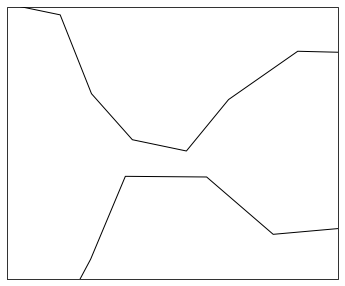

In [9]:
plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines(resolution='110m', color='k')
ax.set_extent(box, crs=ccrs.PlateCarree())


## FESOM2 example (data on vertices)

Select the region:

In [10]:
elem_no_nan, no_nan_triangles = cut_region(model_lon, model_lat, elements, box)
no_cyclic_elem2 = get_no_cyclic(model_lon, model_lat, elem_no_nan)
# data_to_plot[data_to_plot == 0] = -99999
elem_to_plot = elem_no_nan[no_cyclic_elem2]

And plot, as simple as that :) Note, that data are interpolated to triangles from vertices, so you still don't see the exact values, but it is representative of what is going on in the model.

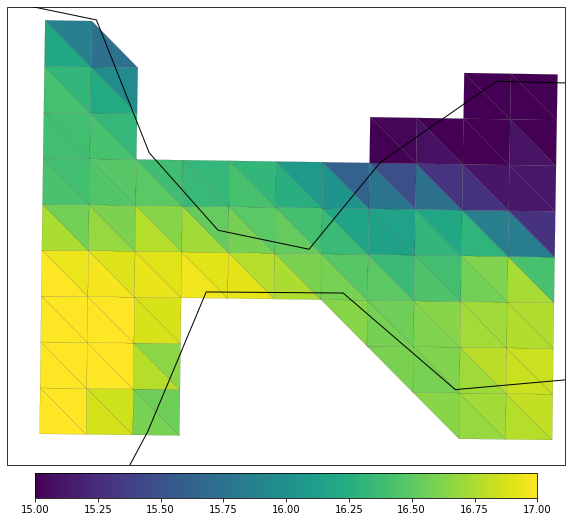

In [11]:
plt.figure(figsize=(10,15))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines(resolution='110m', color='k')
ax.set_extent(box, crs=ccrs.PlateCarree())
image = ax.tripcolor(
                model_lon,
                model_lat,
                elem_to_plot,
                data_sample,
                transform=ccrs.PlateCarree(),
                edgecolors="k",
                vmin = 15,
                vmax = 17,
                lw=0.1,
                alpha=1,
            )
plt.colorbar(
        image, orientation="horizontal", ax=ax, pad=0.01, shrink=0.9, 
    )

## ICON-o example, data on elements

Most of the ICON data are located at elements, so we use a bit different procedure. FESOM2 data located on elements (e.g. UV) can be plotted the same way.

In [12]:
data_to_plot_icon = data_sample_icon
elem_no_nan_icon, no_nan_triangles_icon = cut_region(icon_lon, icon_lat, elementsICON, box)
no_cyclic_elem2_icon = get_no_cyclic(icon_lon, icon_lat, elem_no_nan_icon)
data_to_plot_icon = data_to_plot_icon[no_nan_triangles_icon][no_cyclic_elem2_icon]
elem_to_plot_icon = elem_no_nan_icon[no_cyclic_elem2_icon]

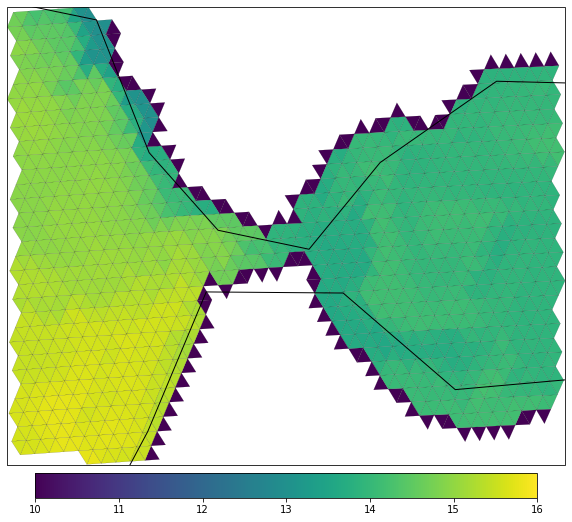

In [13]:
plt.figure(figsize=(10,15))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines(resolution='110m', color='k')
ax.set_extent(box, crs=ccrs.PlateCarree())
image = ax.tripcolor(
                icon_lon,
                icon_lat,
                elem_to_plot_icon,
                data_to_plot_icon,
                transform=ccrs.PlateCarree(),
                edgecolors="k",
                vmin = 10,
                vmax = 16,
                lw=0.1,
                alpha=1,
            )
plt.colorbar(
        image, orientation="horizontal", ax=ax, pad=0.01, shrink=0.9, 
    )

The only difference between ICON-o and ICON-a in terms of data is the mesh. So let's try to plot some atmospheric surface temperature:

In [14]:
dataICONA = xr.open_dataset('/work/mh0731/m300845/hackathon/dpp0029/raw_model_output/dpp0033/dpp0033_atm4_2d_ml_20210121T000000Z.nc')
gridICONA = xr.open_dataset('/work/mh0731/m300845/hackathon/dpp0029/raw_model_output/dpp0033/icon_grid_0015_R02B09_G.nc')

In [15]:
icona_lon=gridICONA.vlon.data*180./np.pi
icona_lat=gridICONA.vlat.data*180./np.pi

data_sample_icona = dataICONA.ts[0,:].values # to (time, depth, ncells) float32 ...
elementsICONA=gridICONA.vertex_of_cell[:,:].T.values-1

In [16]:
data_to_plot_icona = data_sample_icona
elem_no_nan_icona, no_nan_triangles_icona = cut_region(icona_lon, icona_lat, elementsICONA, box)
no_cyclic_elem2_icona = get_no_cyclic(icona_lon, icona_lat, elem_no_nan_icona)
data_to_plot_icona = data_to_plot_icona[no_nan_triangles_icona][no_cyclic_elem2_icona]
elem_to_plot_icona = elem_no_nan_icona[no_cyclic_elem2_icona]

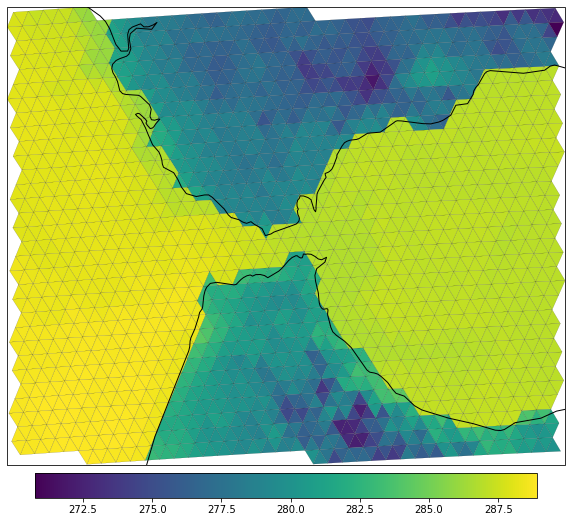

In [17]:
plt.figure(figsize=(10,15))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines(resolution='10m', color='k')
ax.set_extent(box, crs=ccrs.PlateCarree())
image = ax.tripcolor(
                icona_lon,
                icona_lat,
                elem_to_plot_icona,
                data_to_plot_icona,
                transform=ccrs.PlateCarree(),
                edgecolors="k",
                lw=0.1,
                alpha=1,
            )
plt.colorbar(
        image, orientation="horizontal", ax=ax, pad=0.01, shrink=0.9, 
    )